In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cervical-cancer-risk-classification/kag_risk_factors_cervical_cancer.csv


In [2]:
# additional imports

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize']= (10, 10)
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer,recall_score,precision_score,accuracy_score,f1_score,confusion_matrix, plot_confusion_matrix

# Cervical Cancer Risk Factors analysis

## Business Understanding

The data is represented by 32 risk factors, including demographic information, patient’s habits and historic medical records. Meanwhile, there are 4 target variables or labels: Hinselmann, Schiller, Cytology and Biopsy ([here](https://ieeexplore.ieee.org/document/8070120)). 

I am going to use the Biopsy label to answer the following questions:

- Which is more likely to lead to a biopsy between smoking or birth control?
- How sexual activness is linked to a biopsy request?
- Are STDs more linked to a biopsy?
- What relates to a request for a biopsy?

## Data Understanding

### Column descriptions

- Age: *Age of the patient*

- Number of sexual partners: *# of sexual partners of the patient*

- First sexual intercourse: *First sexual intercourse age of the patient*

- Num of pregnancies: *# of pregnancies of the patient*

- Smokes: *Whether the patient is a smoker*

- Smokes (years): *For how long (years) the patient was a smoker*

- Smokes (packs/year): *# of packs of cigarettes oer year*

- Hormonal Contraceptives: *Whether the patient uses Hormonal Contraceptives*

- Hormonal Contraceptives (years): *Whether the patient is on Hormonal Contraceptives*

- IUD: *Whether the patient has a IUD*

- IUD (years): *For how long (years) the patient had a IUD*

- STDs: *Whether the patient has a STDs*

- STDs (number): *# of STDs the patient have or had*

- STDs:condylomatosis: *Disease Flag*

- STDs:cervical condylomatosis: *Disease Flag*

- STDs:vaginal condylomatosis: *Disease Flag*

- STDs:vulvo-perineal condylomatosis: *Disease Flag*

- STDs:syphilis: *Disease Flag*

- STDs:pelvic inflammatory disease: *Disease Flag*

- STDs:genital herpes: *Disease Flag*

- STDs:molluscum contagiosum: *Disease Flag*

- STDs:AIDS: *Disease Flag*

- STDs:HIV: *Disease Flag*

- STDs:Hepatitis B: *Disease Flag*

- STDs:HPV: *Disease Flag*

- STDs: Number of diagnosis: *Number of STDs diagnosed*

- STDs: Time since first diagnosis: *Time since first diagnosis?*

- STDs: Time since last diagnosis: *Time since last diagnosis?*

- Dx:Cancer: *Cancer diagnosis Flag*

- Dx:CIN: *CIN diagnosis Flag*

- Dx:HPV: *HPV diagnosis Flag*

- Dx: *Diagnosis Flag?*

- Hinselmann: *Hinselmann test scheduled*

- Schiller: *Schiller test scheduled*

- Citology: *Citology test scheduled*

- Biopsy: *Biopsy test scheduled*

In [3]:
data = pd.read_csv('../input/cervical-cancer-risk-classification/kag_risk_factors_cervical_cancer.csv')
data_copy = data.copy()

## Data Preparation

In [4]:
# Replacing the '?' character with NaN as it representsa place holder for missing values

data.replace('?',np.nan, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           832 non-null    object
 2   First sexual intercourse            851 non-null    object
 3   Num of pregnancies                  802 non-null    object
 4   Smokes                              845 non-null    object
 5   Smokes (years)                      845 non-null    object
 6   Smokes (packs/year)                 845 non-null    object
 7   Hormonal Contraceptives             750 non-null    object
 8   Hormonal Contraceptives (years)     750 non-null    object
 9   IUD                                 741 non-null    object
 10  IUD (years)                         741 non-null    object
 11  STDs                                753 non-null    object

In [5]:
data.head(20)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
5,42,3.0,23.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
6,51,3.0,17.0,6.0,1.0,34.0,3.4,0.0,0.0,1.0,...,NaN,NaN,0,0,0,0,1,1,0,1
7,26,1.0,26.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,...,NaN,NaN,0,0,0,0,0,0,0,0
8,45,1.0,20.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1,0,1,1,0,0,0,0
9,44,3.0,15.0,NaN,1.0,1.266972909,2.8,0.0,0.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


**Notes**

- Columns *STDs: Time since first diagnosis, STDs: Time since last diagnosis* lack of available values and they will be remove.
- Columns *Hinselmann, Schiller, Citology* will be removed since I am analyzing the factors that relates to a biopsy.
- Columns *Dx* has no clear explanation and it will therefore dropped.

In [6]:
data.drop(columns=['STDs: Time since first diagnosis','STDs: Time since last diagnosis','Hinselmann','Schiller','Citology'], inplace=True)

#creating Diagnosi Flag column

data['Dx'] = (data['Dx:Cancer']+ data['Dx:CIN']+data['Dx:HPV'])/(data['Dx:Cancer']+ data['Dx:CIN']+data['Dx:HPV'])
data['Dx'].fillna(0, inplace=True)
data.rename(columns={'Dx':'Dx Flag'}, inplace=True)

data.head(10)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx Flag,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,1.0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0
5,42,3.0,23.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0
6,51,3.0,17.0,6.0,1.0,34.0,3.4,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,1
7,26,1.0,26.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0
8,45,1.0,20.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,1.0,0
9,44,3.0,15.0,NaN,1.0,1.266972909,2.8,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0


In [7]:
data.shape

(858, 31)

In [8]:
# Checking the column values

for i in data.columns:
    
    data[i]=data[i].astype('float', errors='ignore')
    print('\n--------------')
    print(i)
    print('\n',data[i].value_counts(dropna=False))


--------------
Age

 23.0    54
18.0    50
21.0    46
20.0    45
19.0    44
25.0    39
24.0    39
26.0    38
28.0    37
30.0    35
17.0    35
29.0    33
27.0    33
22.0    30
35.0    29
33.0    28
31.0    27
34.0    24
36.0    24
16.0    23
15.0    21
32.0    18
37.0    17
41.0    13
40.0    12
38.0     9
39.0     9
42.0     6
44.0     6
45.0     6
14.0     5
43.0     5
46.0     3
49.0     2
70.0     2
48.0     2
52.0     2
13.0     1
50.0     1
51.0     1
47.0     1
79.0     1
59.0     1
84.0     1
Name: Age, dtype: int64

--------------
Number of sexual partners

 2.0     272
3.0     208
1.0     206
4.0      78
5.0      44
NaN      26
6.0       9
7.0       7
8.0       4
9.0       1
28.0      1
10.0      1
15.0      1
Name: Number of sexual partners, dtype: int64

--------------
First sexual intercourse

 15.0    163
17.0    151
18.0    137
16.0    121
14.0     79
19.0     60
20.0     37
13.0     25
21.0     20
22.0      9
23.0      9
NaN       7
26.0      7
12.0      6
24.0      6
2

**Notes**

Several fields contain missing values. I will use a nearest-neighbour approach in order to fill them OR the mode

In [9]:
data.isnull().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

In [10]:
#Filling the missing data

mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data = pd.DataFrame(mode_imputer.fit_transform(data),columns = data.columns)

data.isnull().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


In [11]:
#Creting the Age Bands field

bins = [0,18,66,data.Age.max()]
labels = ['Teen', 'Adult', 'Elder']
data.insert(1, 'Age Bands',pd.cut(data['Age'],bins=bins, labels=labels, include_lowest=True) )

data.head(20)

,Age,Age Bands,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),...,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx Flag,Biopsy
0,18.0,Teen,4.0,15.0,1.0,0.0,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15.0,Teen,1.0,14.0,1.0,0.0,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34.0,Adult,1.0,15.0,1.0,0.0,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,52.0,Adult,5.0,16.0,4.0,1.0,37.000000,37.0,1.0,3.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,46.0,Adult,3.0,21.0,4.0,0.0,0.000000,0.0,1.0,15.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,42.0,Adult,3.0,23.0,2.0,0.0,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,51.0,Adult,3.0,17.0,6.0,1.0,34.000000,3.4,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,26.0,Adult,1.0,26.0,3.0,0.0,0.000000,0.0,1.0,2.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,45.0,Adult,1.0,20.0,5.0,0.0,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
9,44.0,Adult,3.0,15.0,1.0,1.0,1.266973,2.8,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Modeling



**Smokers v Hormonal control**

In [12]:
#Selecting only the smokers
smokers = data[data['Smokes']==1]

smokers_age = smokers.groupby(['Age Bands'])['Biopsy'].mean().reset_index()

#Selecting only the women on Hormonal Contraceptives
on_birth_control = data[data['Hormonal Contraceptives']==1]

on_birth_control_age = on_birth_control.groupby(['Age Bands'])['Biopsy'].mean().reset_index()

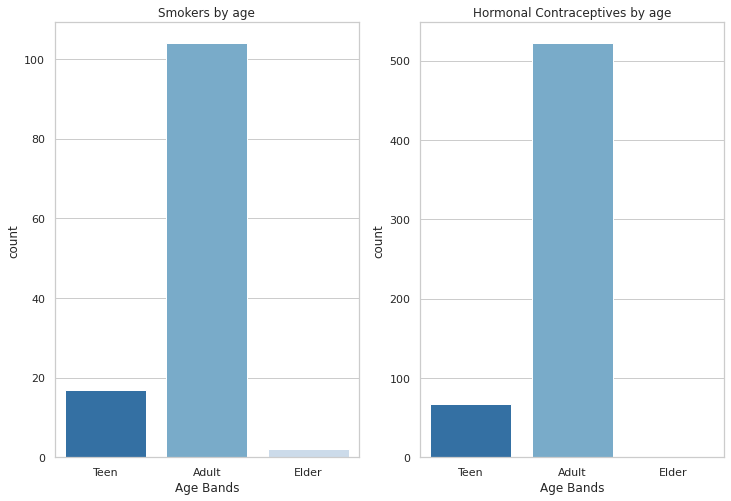

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))

sns.countplot(x='Age Bands', data=smokers,palette='Blues_r', ax=ax1)
ax1.title.set_text('Smokers by age')

sns.countplot(x='Age Bands', data=on_birth_control,palette='Blues_r', ax=ax2)
ax2.title.set_text('Hormonal Contraceptives by age');

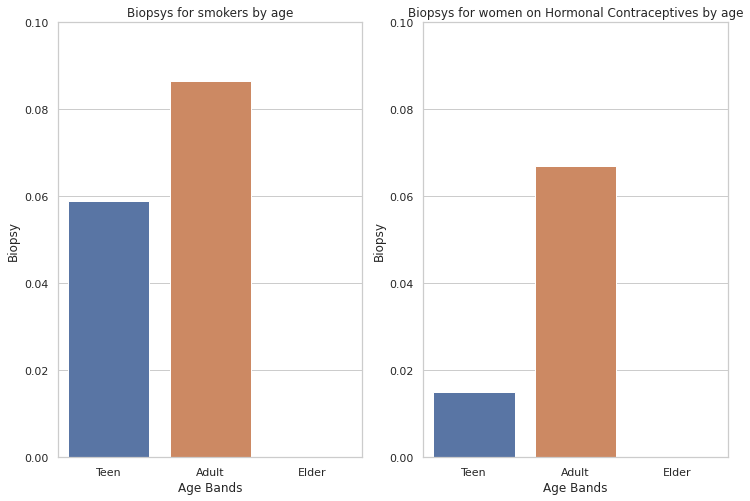

In [14]:
#Plotting the smokers vs the Hormonal Contraceptives women in terms of biopsys

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
sns.barplot(x='Age Bands',y='Biopsy', data=smokers_age, ax=ax1)
ax1.title.set_text('Biopsys for smokers by age')
ax1.set_ylim(0,0.1)

sns.barplot(x='Age Bands',y='Biopsy', data=on_birth_control_age, ax=ax2)
ax2.title.set_text('Biopsys for women on Hormonal Contraceptives by age')
ax2.set_ylim(0,0.1);

**Notes**

- Higher % of Biopsy in both Teens and Adults smokers. Given the different sample sizes and the overall small size of the dataset, the statistical significance of these differences has to be tested by Hypothesis testing.


**Hypothesis Testing the Adults**

$ H^0 $: (smokers_a_mean - on_birth_control_a_mean) = 0

$ H' $: (smokers_a_mean - on_birth_control_a_mean) ≠ 0

In [15]:
smokers_a = smokers[smokers['Age Bands']=='Adult']
smokers_a_mean = smokers_a['Biopsy'].mean()

on_birth_control_a = on_birth_control[on_birth_control['Age Bands']=='Adult']
on_birth_control_a_mean = on_birth_control_a['Biopsy'].mean()

obs_diff = smokers_a_mean - on_birth_control_a_mean
obs_diff

0.019488653109342766

p-value: 0.4527


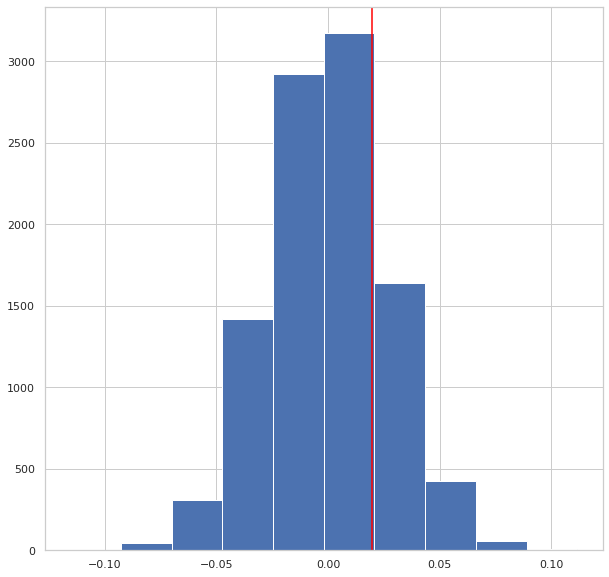

In [16]:
diffs = []

for _ in range(10000):
    b_samp = data.sample(data.shape[0],replace=True)
    
    smokers = b_samp[b_samp['Smokes']==1]
    smokers_a = smokers[smokers['Age Bands']=='Adult']
    smokers_a_mean = smokers_a['Biopsy'].mean()
    
    on_birth_control = b_samp[b_samp['Hormonal Contraceptives']==1]
    on_birth_control_a = on_birth_control[on_birth_control['Age Bands']=='Adult']
    on_birth_control_a_mean = on_birth_control_a['Biopsy'].mean()
    
    diffs.append(smokers_a_mean - on_birth_control_a_mean)


diffs = np.array(diffs)
null_vals = np.random.normal(0,diffs.std(), diffs.size)

print('p-value: {}'.format((null_vals>obs_diff).mean() + (null_vals<(-obs_diff)).mean()))

plt.hist(null_vals)
plt.axvline(x=obs_diff, color='red')
plt.show();

A p-value greater than +/- 0.05 shows how the observed difference comes from the null hypothesis and therefore the observed difference in Biopsys between smokers adults and adults on hormonal contraceptive is **NOT statistically significant**

**Hypothesis Testing the Teens**

In [17]:
smokers_a = smokers[smokers['Age Bands']=='Teen']
smokers_a_mean = smokers_a['Biopsy'].mean()

on_birth_control_a = on_birth_control[on_birth_control['Age Bands']=='Teen']
on_birth_control_a_mean = on_birth_control_a['Biopsy'].mean()

obs_diff = smokers_a_mean - on_birth_control_a_mean
obs_diff

0.0365025466893039

p-value: 0.5575


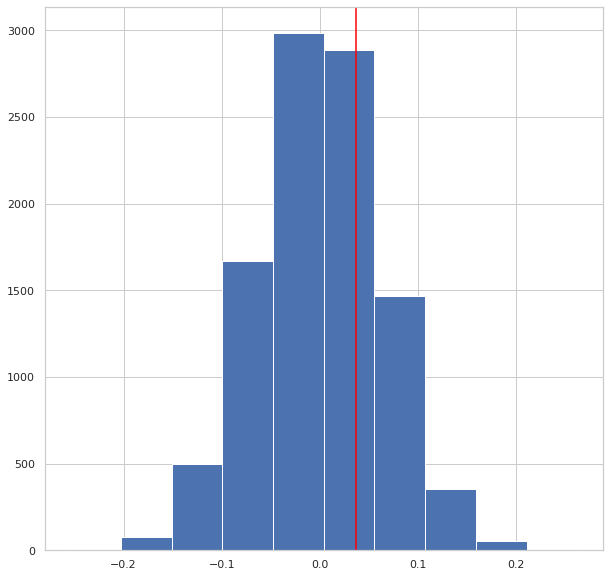

In [18]:
diffs = []

for _ in range(10000):
    b_samp = data.sample(data.shape[0],replace=True)
    
    smokers = b_samp[b_samp['Smokes']==1]
    smokers_a = smokers[smokers['Age Bands']=='Teen']
    smokers_a_mean = smokers_a['Biopsy'].mean()
    
    on_birth_control = b_samp[b_samp['Hormonal Contraceptives']==1]
    on_birth_control_a = on_birth_control[on_birth_control['Age Bands']=='Teen']
    on_birth_control_a_mean = on_birth_control_a['Biopsy'].mean()
    
    diffs.append(smokers_a_mean - on_birth_control_a_mean)


diffs = np.array(diffs)
null_vals = np.random.normal(0,diffs.std(), diffs.size)

print('p-value: {}'.format((null_vals>obs_diff).mean() + (null_vals<(-obs_diff)).mean()))

plt.hist(null_vals)
plt.axvline(x=obs_diff, color='red')
plt.show();

A p-value greater than +/- 0.05 shows how the observed difference comes from the null hypothesis and therefore the observed difference in Biopsys between smokers teens and teens on hormonal contraceptive is **NOT statistically significant**

### Sexually activness

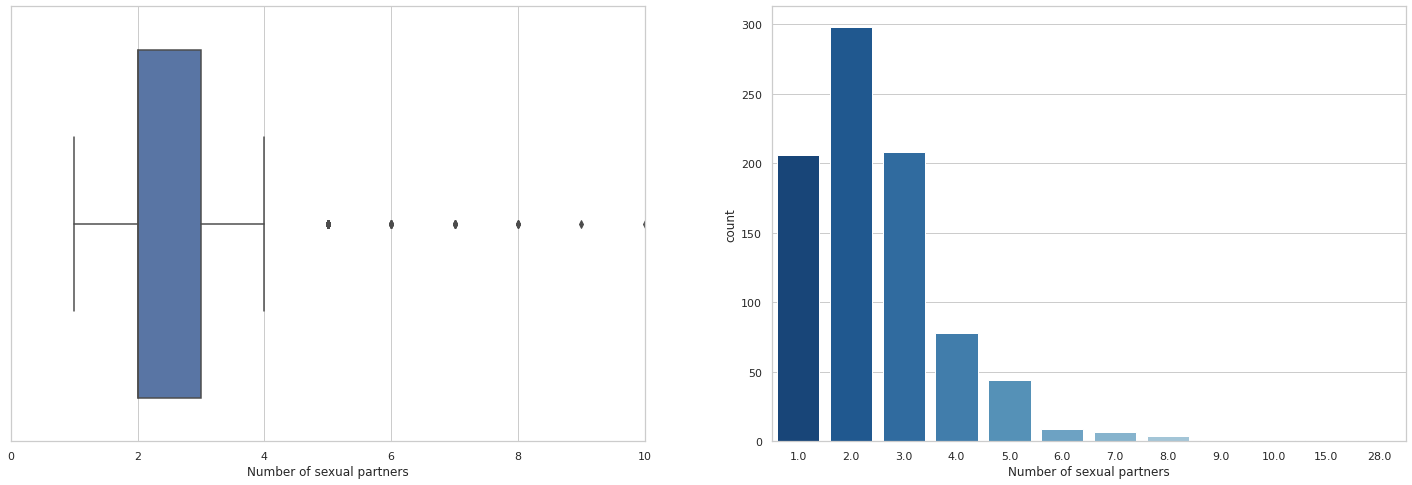

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,8))

sns.boxplot(x='Number of sexual partners', data=data, ax=ax1)
ax1.set_xlim([0, 10])

sns.countplot(x='Number of sexual partners', data=data,palette='Blues_r', ax=ax2);

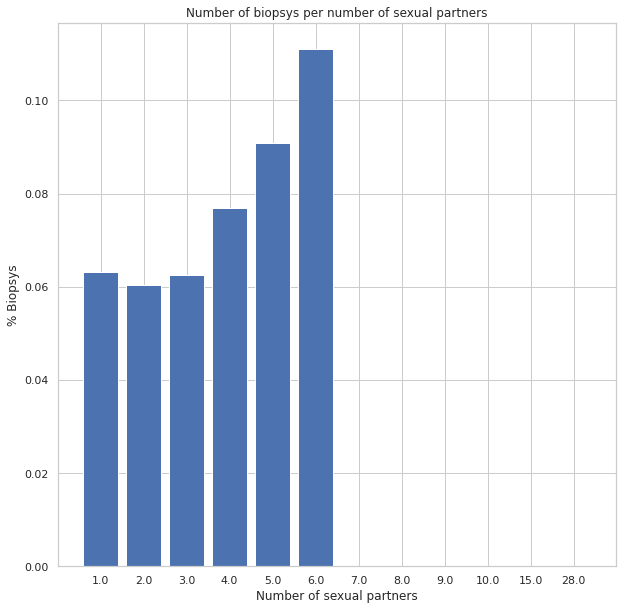

In [20]:
#counting the number of biopsys per number of sexual partners
sex_partners = data.groupby(['Number of sexual partners'])['Biopsy'].mean().reset_index()
sex_partners['Number of sexual partners'] = sex_partners['Number of sexual partners'].astype('str')
plt.bar(x='Number of sexual partners', height='Biopsy', data=sex_partners)
plt.title('Number of biopsys per number of sexual partners')
plt.xlabel('Number of sexual partners')
plt.ylabel('% Biopsys');

**Notes**

- Higher % of Biopsy in women who had more than 3 sexual partners. However, given the different sample sizes and the overall small size of the dataset, the statistical significance of this difference has to be tested by Hypothesis testing.

$ H^0 $: (three_more_ptner_mean - four_less_ptner_mean) = 0

$ H' $: (three_more_ptner_mean - four_less_ptner_mean) ≠ 0

In [21]:
three_less_ptner_mean = data[data['Number of sexual partners'] <= 3]['Biopsy'].mean()
four_more_ptner_mean = data[data['Number of sexual partners'] > 3]['Biopsy'].mean()

obs_diff = four_more_ptner_mean - three_less_ptner_mean
obs_diff

0.013544712944435891

In [22]:
def hyp_testing(df,col_group,col_label,value):

    diffs = []

    for _ in range(10000):
        b_samp = df.sample(df.shape[0],replace=True)
        less_mean = b_samp[b_samp[col_group] <= value][col_label].mean()
        more_mean = b_samp[b_samp[col_group] > value][col_label].mean()
        diffs.append(more_mean - less_mean)


    diffs = np.array(diffs)
    null_vals = np.random.normal(0,diffs.std(), diffs.size)

    print('p-value: {}'.format((null_vals>obs_diff).mean() + (null_vals<(-obs_diff)).mean()))

    plt.hist(null_vals)
    plt.axvline(x=obs_diff, color='red')
    plt.show();

p-value: 0.5591999999999999


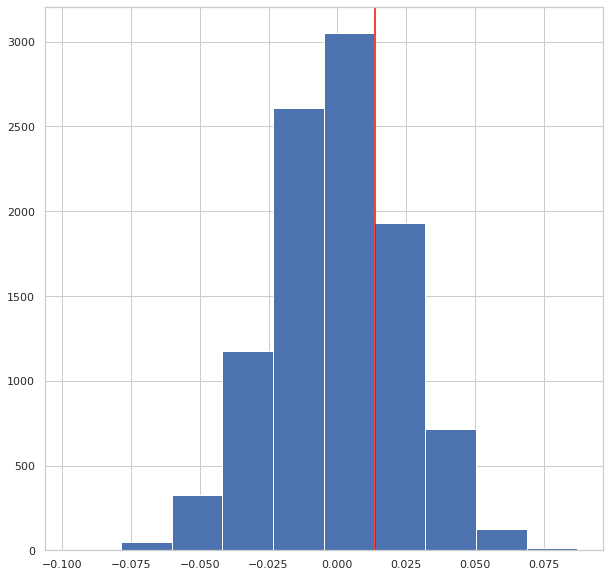

In [23]:
hyp_testing(data,'Number of sexual partners','Biopsy',3)

A p-value greater than +/- 0.05 shows how the observed difference comes from the null hypothesis and therefore the observed difference in Biopsys between women who had more than 3 partner and those who had less is **NOT statistically significant**

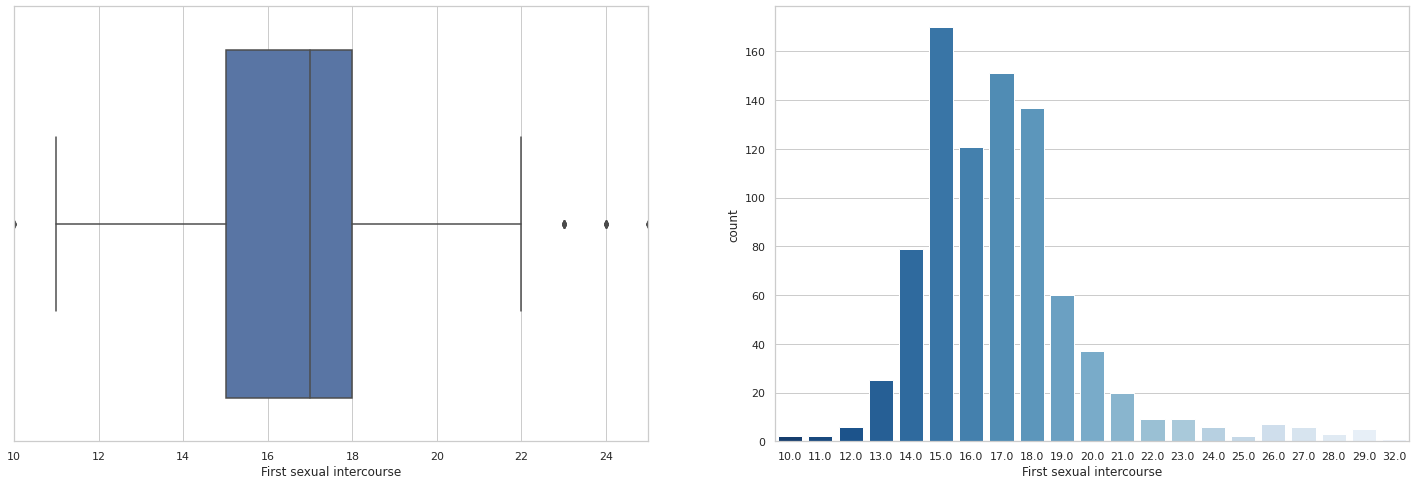

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,8)) # , figsize=(5,10)

sns.boxplot(x='First sexual intercourse', data=data, ax=ax1)
ax1.set_xlim([10, 25])

sns.countplot(x='First sexual intercourse', data=data,palette='Blues_r', ax=ax2);

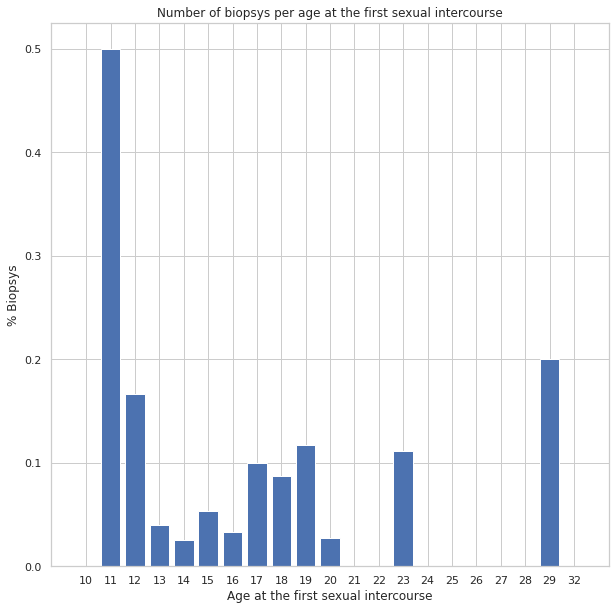

In [25]:
#counting the number of biopsys per age at the first sexual intercourse

first_intercourse = data.groupby(['First sexual intercourse'])['Biopsy'].mean().reset_index()
first_intercourse['First sexual intercourse'] = first_intercourse['First sexual intercourse'].astype('int')
first_intercourse['First sexual intercourse'] = first_intercourse['First sexual intercourse'].astype('str')
plt.bar(x='First sexual intercourse', height='Biopsy', data=first_intercourse)
plt.title('Number of biopsys per age at the first sexual intercourse')
plt.xlabel('Age at the first sexual intercourse')
plt.ylabel('% Biopsys');

**Notes**

The boxplot shows that the bulk of the records are within the 15-18 years old range. In the subsequent barchart we can see an increase in biopsys after age 16. However, given the different sample sizes and the overall small size of the dataset, the statistical significance of this difference has to be tested by Hypothesis testing.

$ H^0 $: (more_f_sex_mean - less_f_sex_mean) = 0

$ H' $: (more_f_sex_mean - less_f_sex_mean) ≠ 0

In [26]:
less_f_sex_mean = data[data['First sexual intercourse'] <= 16]['Biopsy'].mean()
more_f_sex_mean = data[data['First sexual intercourse'] > 16]['Biopsy'].mean()

obs_diff = more_f_sex_mean - less_f_sex_mean
obs_diff

0.03723325974981604

p-value: 0.0278


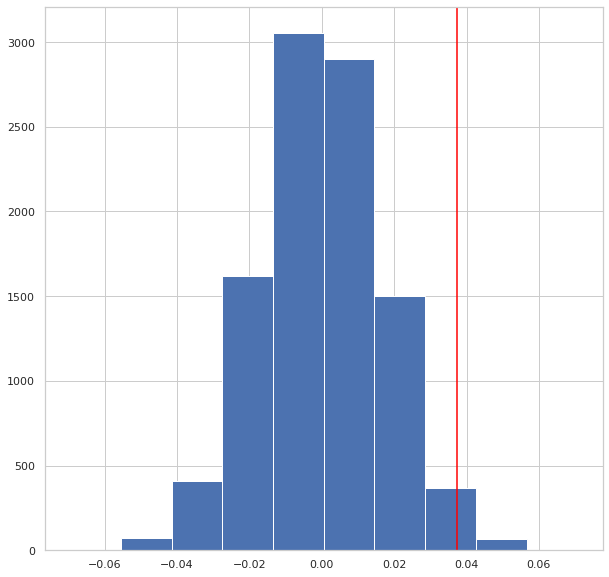

In [27]:
hyp_testing(data,'First sexual intercourse','Biopsy',16)

A p-value smaller than 0.05 rejects the null hypothesis and therefore the observed difference in Biopsys between women who had their first sexual intercourse after 16 years old and those who were younger **IS statistically significant**

### STDs

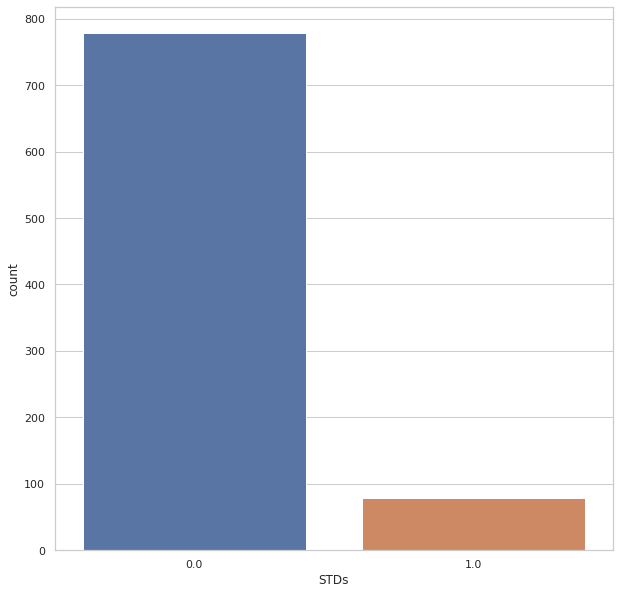

In [28]:
sns.countplot(x='STDs', data=data);

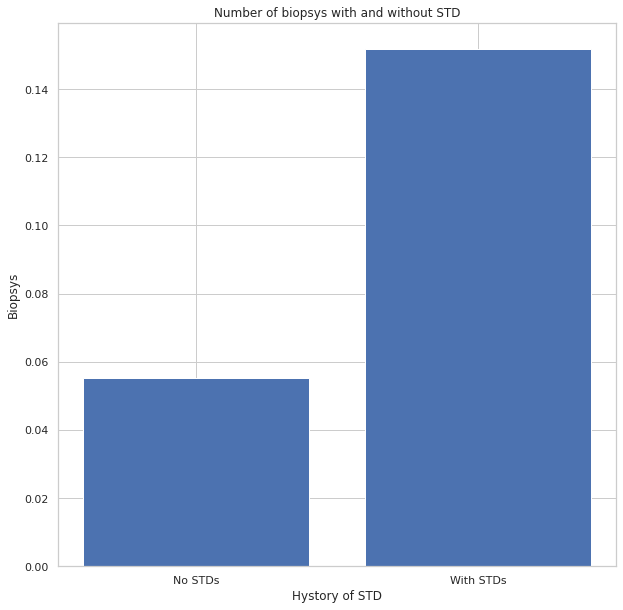

In [29]:
#counting number of biopsys per number of STD
tot_std = data.groupby(['STDs'])['Biopsy'].mean().reset_index()
tot_std['STDs'].replace({0:'No STDs', 1:'With STDs'}, inplace=True)
plt.bar(x='STDs', height='Biopsy', data=tot_std)
plt.title('Number of biopsys with and without STD')
plt.xlabel('Hystory of STD')
plt.ylabel('Biopsys');

**Notes**

- Higher % of Biopsy in women who have hystory of STDs. However, given the different sample sizes and the overall small size of the dataset, the statistical significance of this difference has to be tested by Hypothesis testing.

$ H^0 $: (yes_std_mean - no_std_mean) = 0

$ H' $: (yes_std_mean - no_std_mean) ≠ 0

In [30]:
no_std_mean = data[data['STDs'] <= 0]['Biopsy'].mean()
yes_std_mean = data[data['STDs'] > 0]['Biopsy'].mean()

obs_diff = yes_std_mean - no_std_mean
obs_diff

0.0966997611348532

p-value: 0.0171


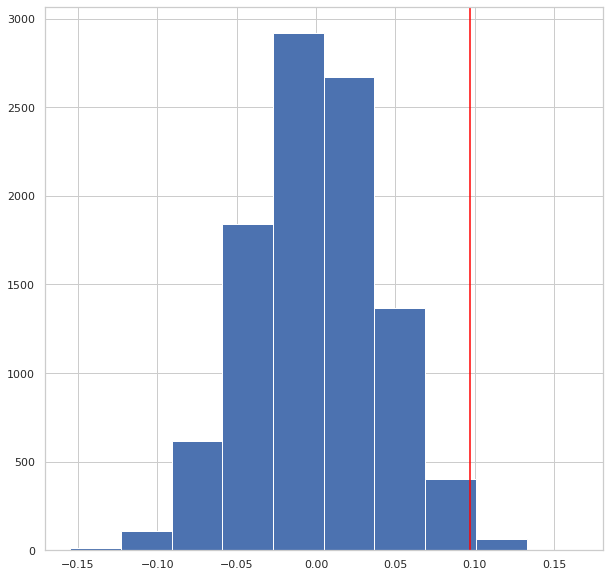

In [31]:
hyp_testing(data,'STDs','Biopsy',0)

A p-value smaller than 0.05 rejects the null hypothesis and therefore the observed difference in Biopsys between women with hystory of STDs and those without one  **IS statistically significant**

### Biopsy related features

In [32]:
data.drop(columns=['Age Bands','Dx Flag'], inplace=True)
data.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Biopsy
0,18.0,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15.0,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34.0,1.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,52.0,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,46.0,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
data_shuffled = data.sample(n=data.shape[0])

test_size = round(data_shuffled.shape[0]*0.2)

# splitting data into train and test sets
df_train = data_shuffled.iloc[test_size:]
df_test = data_shuffled.iloc[:test_size]

**Oversampling**

In [34]:
biop_one = df_train[df_train['Biopsy']==1]
biop_zero = df_train[df_train['Biopsy']==0]

In [35]:
biop_zero.shape[0],biop_one.shape[0]

(639, 47)

In [36]:
biop_zero.shape[0]-biop_one.shape[0]

592

In [37]:
over_samp = biop_one.sample(n=(biop_zero.shape[0]-biop_one.shape[0]), replace=True)
over_samp.shape[0]

592

In [38]:
df_train_over = pd.concat([biop_zero,biop_one,over_samp])
df_train_over

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Biopsy
168,29.0,4.0,16.0,3.0,0.0,0.0,0.00,0.0,0.00,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381,19.0,3.0,15.0,2.0,0.0,0.0,0.00,1.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525,17.0,1.0,16.0,1.0,0.0,0.0,0.00,1.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843,30.0,3.0,14.0,3.0,0.0,0.0,0.00,1.0,2.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
463,14.0,1.0,14.0,2.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,25.0,6.0,17.0,2.0,0.0,0.0,0.00,1.0,2.00,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
23,40.0,1.0,20.0,2.0,0.0,0.0,0.00,1.0,15.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
41,37.0,2.0,18.0,1.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
203,28.0,2.0,19.0,2.0,0.0,0.0,0.00,1.0,0.42,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [39]:
df_train_over['Biopsy'].value_counts()

1.0    639
0.0    639
Name: Biopsy, dtype: int64

In [40]:
X_train = df_train_over.drop(columns=['Biopsy'])
y_train = df_train_over['Biopsy']

X_test = df_test.drop(columns=['Biopsy'])
y_test = df_test['Biopsy']

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [42]:
X_test_scaled.shape

(172, 29)

In [43]:
%%time

scorer = make_scorer(recall_score)

rf=RandomForestClassifier()

rf_par_grid = {'n_estimators': [500,700,1000], 'criterion':['gini','entropy'],'max_depth': [10,20,50], 'min_samples_leaf': [4,6,8]}

grid_rf = GridSearchCV(estimator= rf, param_grid= rf_par_grid, scoring=scorer, cv=5)
grid_rf_fit = grid_rf.fit(X_train_scaled, y_train)

CPU times: user 7min 53s, sys: 2.61 s, total: 7min 56s
Wall time: 7min 56s


In [44]:
grid_rf.best_estimator_

RandomForestClassifier(max_depth=50, min_samples_leaf=4, n_estimators=700)

In [45]:
y_pred = grid_rf_fit.predict(X_test_scaled)

recall_score(y_test, y_pred),precision_score(y_test, y_pred)

(0.0, 0.0)

In [46]:
confusion_matrix(y_test,y_pred)

array([[152,  12],
       [  8,   0]])

**Notes**

The test size contains a too small number of 1s for the ML algorithm to work properly, however I am not training Random Forest to predict whether future patients will undergo a biopsy. I am using Random Forest in order to evaluate which features are more linked to a biopsy request, therefore I can use the training set for this purpose. It won't give a definitive answer but rather an indication, which can be later compared to the Hypothesis testing results above.

Another solution would be extend the oversampling in order to obtain a test set with at least 100 records where Biopsy==1. In my opinion, this will introduce to much overfitting for a reliable results.

Without a bigger dataset, I believe that using the training set would be the best option.

In [47]:
y_pred = grid_rf_fit.predict(X_train_scaled)

recall_score(y_train, y_pred),precision_score(y_train, y_pred), accuracy_score(y_train,y_pred)

(0.9843505477308294, 0.9691833590138675, 0.9765258215962441)

In [48]:
arr = grid_rf_fit.best_estimator_.feature_importances_
idx = np.argsort(arr)[-10:]
data.columns[idx]

for i in range(1,11):
    idx = np.argsort(arr)[-i:]
    print(str(i) + ': '+data.columns[idx][0]+'\n')

1: Hormonal Contraceptives (years)

2: Age

3: First sexual intercourse

4: Number of sexual partners

5: Num of pregnancies

6: Dx:HPV

7: Dx:Cancer

8: Smokes (years)

9: STDs: Number of diagnosis

10: Smokes (packs/year)



## Conclusions

**Which is more likely to lead to a biopsy between smoking or birth control?**

Despite a different percentage of biopsy between smokers and patients on birth control in favor of the former, the hypothesis testing showed how that difference is not statistically significant. Moreover, the Random Forest feature importance analysis showed how they are both in the top 10 features leading to a biopsy request, with 'Hormonal Contraceptives (years)' being the number 1.

**How sexual activness is linked to a biopsy request?**

No significant difference was observed in biopsy rate between women who had more than 3 sexual partners and women who had up to 3 sexual partners. However, the Random Forest feature importance analysis indicates otherwise.
More data are needed in order to further investigate the relationship between 'Number of sexual partners' and biopsy

Furthermore, both the Random Forest feature importance analysis and the hypothesis testing indicated that the age at the first sexual intercourse is one of the main drivers for a biosy request. More specifically, the increase observed in biopsy percentage in women who were older than 17 years old on their first time it is statistically significant.

**Are STDs more linked to a biopsy?**

Although the STD flag feature ('STDs') is not among the top 10 features leading to a biopsy request, the hypothesis testing showed how the increase observed in biopsy percentage in women with at least one STD it is statistically significant. As mentioned, the feature importance analysis outcome is more an indication than a concrete result due to the small size of both the test set and the dataset. More data, in particular regarding biopsys requests, are needed for a more meaningful comparison. 

**What relates to a request for a biopsy?**

The Random Forest feature importance analysis showed how both smoke and birth control, along with age and sexual activness are linked to request of biopsys for cervical cancer with 'Hormonal Contraceptives (years)' being the number 1.
The test size was to small to be used to pull the most important features linked to a biopsys request therefore I had to use the training. For this reason, the outcome although has value, must be taken as an indication rather than absolute truth.